In [2]:
import torch
from datasets import load_dataset
from rouge import Rouge
import transformers
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import transformers
from trainer import Trainer
from torch.utils.data import DataLoader
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
import wandb
from logger import log_metrics
#import gradient checkpointing
from torch.utils.checkpoint import checkpoint_sequential
import numpy as np

class XSumDatasetPowerLaw(torch.utils.data.Dataset):
    def __init__(self, model_name = 'google/pegasus-large', max_length=256, split = 'train', first_selection = 1, divisor = 2):
        self.tokenizer = PegasusTokenizer.from_pretrained(model_name)
        self.tokenizer.max_length = max_length
        self.dataset = load_dataset("xsum", split = split)
        self.max_length = max_length
        self.first_selection = first_selection
        self.probability = np.ones(1000) * 1000000
        for i, val in enumerate(self.probability):
            if i == 0: continue
            self.probability[i] = self.probability[i-1] / divisor
        self.indexes = np.arange(1000)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.dataset[idx]['document']
        text = text.split('.')
        
        max_idx = max(1, len(text))
        choices = np.random.choice(self.indexes[:max_idx], max_idx, replace = False, p = self.probability[:max_idx] / self.probability[:max_idx].sum())

        current_size = 0
        counter = 0
        while current_size < self.max_length and counter < max_idx:
            current_size += len(text[choices[counter]])
            counter += 1

        choices = sorted(choices[:counter])
        final = list(np.array(text)[choices])
        text = '. '.join(final)

        summary_text = self.dataset[idx]['summary']
        return {'article_text':text, 'summary_text': summary_text}

class PegasusCNNPowerLaw(torch.utils.data.Dataset):
    def __init__(self, model_name = 'google/pegasus-large', max_length=256, split = 'train', divisor = 2):
        self.tokenizer = PegasusTokenizer.from_pretrained(model_name)
        self.tokenizer.max_length = max_length
        self.dataset = load_dataset('cnn_dailymail', '3.0.0', split = split)
        self.max_length = max_length
        self.probability = np.ones(1000) * 1000000
        for i, val in enumerate(self.probability):
            if i == 0: continue
            self.probability[i] = self.probability[i-1] / divisor
        self.indexes = np.arange(1000)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.dataset[idx]['article']
        text = text.split('. ')
        
        max_idx = max(1, len(text))
        choices = np.random.choice(self.indexes[:max_idx], max_idx, replace = False, p = self.probability[:max_idx] / self.probability[:max_idx].sum())

        current_size = 0
        counter = 0
        while current_size < self.max_length and counter < max_idx:
            current_size += len(text[choices[counter]])
            counter += 1

        choices = sorted(choices[:counter])
        final = list(np.array(text)[choices])
        text = '. '.join(final)

        summary_text = self.dataset[idx]['summary']
        return {'article_text':text, 'summary_text': summary_text}

dataset = PegasusCNNPowerLaw(split = 'train', max_length = 256, divisor=2)
dataloader = DataLoader(dataset, batch_size = 2, shuffle = True)
for data in dataloader:
    break
data['article_text']

Found cached dataset cnn_dailymail (/home/da2986/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


KeyError: 'summary'

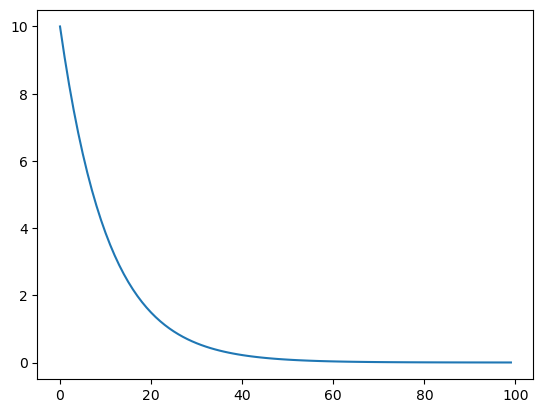

In [7]:
from scipy.stats import powerlaw
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 1)
x = np.ones(100) * 10
for i, val in enumerate(x):
    if i == 0:
        continue
    x[i] = x[i - 1] / 1.1
ax.plot(x)

In [17]:
words = ['Sir Nicholas Wall, president of the Family Division of the High Court, told the Times that women tended to lose out under the current system', '\nThis was because there was an absence of any law on dividing up the assets of couples who lived together, he said', '\nSir Nicholas said judges should be able to decide on claims in such situations', '\nHe said the courts would be more sympathetic to a claim for rights where a couple had lived together for a long time', '\nSir Nicholas said: "I am in favour of cohabitees having rights because of the injustice of the present situation', '\n"Women cohabitees, in particular, are severely disadvantaged by being unable to claim maintenance and having their property rights determined by the conventional laws of trusts', '"\nHe added: "If cohabitation has been short and the contribution minimal, judges would not be sympathetic to a claim', '"\nSir Nicholas was giving his first national newspaper interview since becoming president of the Family Division last year', '\nIn 2007 the Law Commission called for new legal rights for people living together in long-term relationships', '\nSir Nicholas said he was "disappointed" the government had not acted to bring about the changes', '\nAnd the 65-year-old married father-of-four denied that the moves he was proposing may undermine the institution of marriage', '\n"Marriage undoubtedly remains the most stable relationship for bringing up children and for support," he said', '']

In [23]:
len(words[:])


13